In [1]:
import torch
from torch import nn

import numpy as np

In [2]:
text = ['hey how are you','good i am fine','have a nice day']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [3]:
# Finding the length of the longest string in our data
maxlen = len(max(text, key=len))

# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of
# the sentence matches the length of the longest sentence
for i in range(len(text)):
  while len(text[i])<maxlen:
      text[i] += ' '

In [4]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
  input_seq.append(text[i][:-1])
    
    # Remove first character for target sequence
  target_seq.append(text[i][1:])
  print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: hey how are yo
Target Sequence: ey how are you
Input Sequence: good i am fine
Target Sequence: ood i am fine 
Input Sequence: have a nice da
Target Sequence: ave a nice day


In [5]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [6]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [7]:
dict_size

17

In [8]:
# Input shape --> (Batch Size, Sequence Length, One-Hot Encoding Size)
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)

In [9]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

In [10]:
target_seq[0]

tensor([ 6.,  1., 13., 10., 16.,  5., 13., 12.,  7.,  6., 13.,  1., 16., 15.])

In [11]:
int2char[9]

'g'

In [12]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [13]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        #self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [14]:
# Instantiate the model with hyperparameters
model = Model(input_size=17, output_size=17, hidden_dim=15, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    input_seq.to(device)
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100............. Loss: 2.3459
Epoch: 20/100............. Loss: 1.9338
Epoch: 30/100............. Loss: 1.4234
Epoch: 40/100............. Loss: 0.9391
Epoch: 50/100............. Loss: 0.5607
Epoch: 60/100............. Loss: 0.3377
Epoch: 70/100............. Loss: 0.2152
Epoch: 80/100............. Loss: 0.1504
Epoch: 90/100............. Loss: 0.1148
Epoch: 100/100............. Loss: 0.0940


In [16]:
# This function takes in the model and character as arguments and returns the next character prediction and hidden state
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character.to(device)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [17]:
# This function takes the desired output length and input characters as arguments, returning the produced sentence
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [18]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [20]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

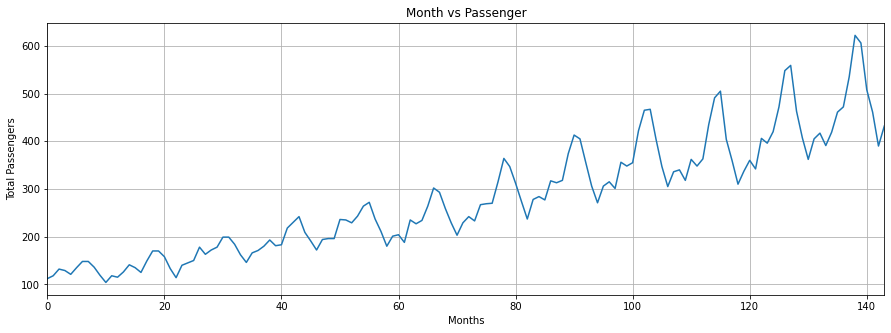

In [21]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
all_data = flight_data['passengers'].values.astype(float)

In [22]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [23]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
print(train_data_normalized[:5])
print(train_data_normalized[-5:])
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [25]:
train_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[0][0]

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])

In [26]:
train_data_normalized[:13]

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385, -0.9516])